In [554]:
import altair as alt
import pandas as pd
from vega_datasets import data
import networkx as nx
import matplotlib.pyplot as plt
import nx_altair as nxa
from itertools import chain
from pyvis.network import Network
import numpy as np
import random
import copy
import matplotlib
import seaborn as sns

In [371]:
#!pip install nx_altair

### Making a heatmap visual representation of connectivity between Topics using jaccard similarity of mutual repositories

In [548]:
tr_list = repo_topic_relation.groupby("topic_simple")["id"].agg(list)
TR = [(len(r),t, r) for t,r in zip(tr_list.index, tr_list)]
TR.sort(reverse=True)
tr_dict = {t:r for l,t,r in TR[:75]}
labels = list(tr_dict.keys())

In [551]:
heatmap_array = []
for t1 in tr_dict:
    current_t1 = []
    for t2 in tr_dict:
        shared = set(tr_dict[t1])&set(tr_dict[t2])
        shared_len = len(shared)
        total_len = len(set(tr_dict[t1])|set(tr_dict[t2]))
        if t1==t2:
            current_t1.append(0)
        else:
            current_t1.append(shared_len/total_len)
    heatmap_array.append(current_t1)
heatmap_array = np.array(heatmap_array)

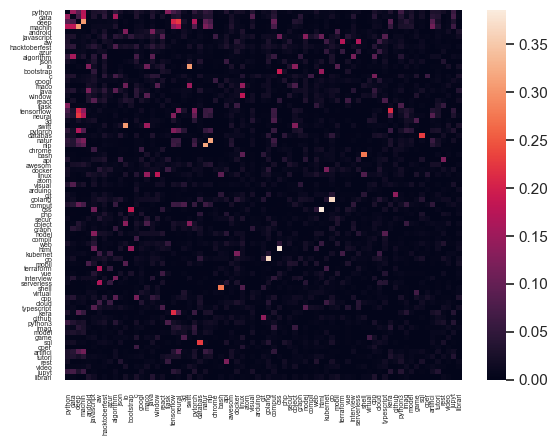

In [553]:
ax = sns.heatmap(heatmap_array, xticklabels=labels, yticklabels=labels)
ax.set_yticklabels(ax.get_yticklabels(), size = 5)
ax.set_xticklabels(ax.get_xticklabels(), size = 5)
plt.show()

### Build class for easy network visualization

In [477]:
# Read our cleaned data
repos = pd.read_csv('../cleaned_data/repo_info_stop75.csv', index_col=0).drop_duplicates(subset=['name']).drop(columns='topics')
contributors = pd.read_csv('../raw_data/10_contributor_info_all.csv', index_col=0).drop_duplicates(subset=['login'])
repo_contrib_relation = pd.read_csv('../raw_data/repo_contributor_relationship_table_all.csv', index_col=0)
repo_topic_relation = pd.read_csv('../cleaned_data/topic_relationship_table_stop75.csv', index_col=0).reset_index(drop=True)

In [416]:
def random_color_gen():
    return ("#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]))

def rc_width_func(df, x):
    contrib_followers = [df.loc[c,'followers'] for c in x if c in df.index]
    if contrib_followers:
        return min(2000,int(np.average(contrib_followers)))
    else:
        return 1
    
def color_func(color_dict, x, df,column):
    if x in list(df.index):
        return color_dict[df.loc[x,column]]
    else:
        return {"border": "black","background": "black"}
    

In [454]:
class social_network:
    """
    The social network class is the main object of this data visualization.
    """
    
    def __init__(self):
        
        #load all scraped datasets
        self.repos = pd.read_csv('../cleaned_data/repo_info_stop75.csv', index_col=0).drop_duplicates(subset=['name'])
        self.contributors = pd.read_csv('../raw_data/10_contributor_info_all.csv', index_col=0).drop_duplicates(subset=['login'])
        self.repo_contrib_relation = pd.read_csv('../raw_data/repo_contributor_relationship_table_all.csv', index_col=0)
        self.repo_topic_relation = pd.read_csv('../cleaned_data/topic_relationship_table_stop75.csv', index_col=0).reset_index(drop=True)
        
        #create an empty dictionary for future edge lists
        self.edgeList_dict = dict()
        self.get_mappings()
        
        
        self.tr_options = {
              "nodes":{
                  "labelHighlightBold": True,
                  "scaling": {
                      "min": 1,
                      "max": 50
                  }
              },
              "edges":{
                  "color":{"inherit": True},
                  "font":{"color": "rgba(52,52,52,0)","size":0,"background": "rgba(52,52,52,0)","strokeColor": "rgba(255,255,255,0)"},
                  "smooth":True,
                  "labelHighlightBold": False
              },
              "physics":{
                  "barnesHut": {"damping": 1}
              }
        }
        self.rc_options = {
              "nodes":{
                  "font":{"size":5},
                  "labelHighlightBold": False,
                  "scaling": {
                      "min": 1,
                      "max": 40
                  }
              },
              "edges":{
                  "color":{"inherit": True},
                  "font":{"color": "rgba(52,52,52,0)","size":0,"background": "rgba(52,52,52,0)","strokeColor": "rgba(255,255,255,0)"},
                  "smooth":False,
                  "labelHighlightBold": False
              },
              "physics":{
                  "barnesHut": {"damping": 1}
              }
        }
        self.tc_options = {
              "nodes":{
                  "labelHighlightBold": True,
                  "scaling": {
                      "min": 1,
                      "max": 50
                  }
              },
              "edges":{
                  "color":{"inherit": True},
                  "font":{"color": "rgba(52,52,52,0)","size":0,"background": "rgba(52,52,52,0)","strokeColor": "rgba(255,255,255,0)"},
                  "smooth":True,
                  "labelHighlightBold": False
              },
              "physics":{
                  "barnesHut": {"damping": 1}
              }
        }
        
        self.options = {'topic-repo':self.tr_options,
                       'topic-contributor':self.tc_options,
                       'repo-contributor':self.rc_options}

        self.width_functions = {'topic-repo':lambda x,y: x,
                               'topic-contributor':lambda x,y: x,
                               'repo-contributor':lambda x,y: rc_width_func(self.contributors, y)
                               }
        self.size_functions = {'topic-repo':lambda x,y: y,
                               'topic-contributor':lambda x,y: y,
                               'repo-contributor':lambda x,y: min(3000,self.repos.loc[x,'stargazers_count']) \
                                                              if x in list(self.repos.index) else 1
                              }
        self.color_functions = {'topic-repo':lambda x, y: {"border": "rgba(126,80,233,1)",
                                                        "background": "rgba(225,213,252,1)",
                                                       "highlight":{"border": "rgba(126,80,233,1)","background": "rgba(225,213,252,1)"}},
                               'topic-contributor':lambda x,y : {"border": "rgba(126,80,233,1)",
                                                        "background": "rgba(225,213,252,1)",
                                                       "highlight":{"border": "rgba(126,80,233,1)","background": "rgba(225,213,252,1)"}},
                               'repo-contributor':lambda x,y: color_func(self.language_colors, x, self.repos, 'language_coloring') if y=='language' \
                                                              else color_func(self.searchword_colors, x, self.repos, 'search_word')
                               }
        #create a color mapping for searchwords
        cmap=plt.cm.gist_ncar
        searchwords = list(self.repos.search_word.unique())
        self.searchword_colors = [(searchwords[i],matplotlib.colors.rgb2hex(cmap(i/len(searchwords)))) for i in range(len(searchwords))]
        self.searchword_colors = {sw:color for sw,color in self.searchword_colors}
        
        #create list of top languages for node coloring
        cmap=plt.cm.tab20
        language_frequency = self.repos.groupby('language').size().sort_values(ascending=False)
        top_languages = list(language_frequency[language_frequency>130].index)
        self.repos['language_coloring'] = [l if l in top_languages else 'Other' for l in self.repos.language]
        self.language_colors = [(top_languages[i],matplotlib.colors.rgb2hex(cmap(i/len(top_languages)))) for i in range(len(top_languages))]+[('Other','#000000')]
        self.language_colors = {l:color for l,color in self.language_colors}
        
        
        #self.searchword_colors = {sw:random_color_gen() for sw in list(self.repos.search_word.unique())}
        
    def change_width_function(self, option, func):
        """
        This method changes the width function for edges given the type of network option.
        
        param option: Specifies which key in the width_function dictionary to change 
                      ('topic-repo', 'topic-contributor','repo-contributor')
        param func: A function that takes in 1 number (int or float) as input
        """
        self.width_functions[option] = func
        
    def change_size_function(self, option, func):
        """
        This method changes the size function for nodes given the type of network option.
        
        param option: Specifies which key in the size_function dictionary to change 
                      ('topic-repo', 'topic-contributor','repo-contributor')
        param func: A function that takes in 1 number (int or float) as input
        """
        self.size_functions[option] = func
    
    def change_mass_function(self, option, func):
        """
        This method changes the mass function for nodes given the type of network option.
        
        param option: Specifies which key in the mass_function dictionary to change 
                      ('topic-repo', 'topic-contributor','repo-contributor')
        param func: A function that takes in 1 number (int or float) as input
        """
        self.mass_functions[option] = func
        
    def remove_small_components(self, graph, n=3):
        for component in list(nx.connected_components(graph)):
            if len(component)<n:
                for node in component:
                    graph.remove_node(node)
        return graph
    
    def get_coloring_legend(self):
        for sw,color in self.searchword_colors.items():
            plt.scatter([],[], color=color, label=sw)

        plt.legend(loc=[-1.25,0])
        plt.show()
        
        for l,color in self.language_colors.items():
            plt.scatter([],[], color=color, label=l)

        plt.legend(loc=[-1.25,0])
        plt.show()
    
    def get_mappings(self):
        """
        This method creates lists for mappings for the three type of networks. 
        
        TR (topic-repo): Maps simplified topics to list of repositories. 
                         [(# of repos, topic, list of repos)]
        TC (topic-contributor): Maps simplified topics to list of contributors to repositories with given topic tag.
                                [(# of contributors, topic, list of contributors)]
        RC (repo-contributor): Maps repositories to list of contributors. 
                               [(# of contributors, repo, list of contributors)]
        """
        #get list of repos for each simplified topic
        self.tr_list = self.repo_topic_relation.groupby("topic_simple")["id"].agg(list)
        self.TR = [(len(r),t, r) for t,r in zip(self.tr_list.index, self.tr_list)]
        self.TR.sort(reverse=True)
        
        #get list of contributors for each repo
        self.rc_list = self.repo_contrib_relation.groupby("Repo")['Contributor'].agg(list)
        self.repo_contrib_dict = dict(zip(self.rc_list.index,self.rc_list))
        self.RC = [(len(c),r, c) for r,c in zip(self.rc_list.index, self.rc_list)]
        self.RC.sort(reverse=True)
        
        #get list of contributors for each simplified topic
        self.TC = list()
        for t,r in zip(self.tr_list.index, self.tr_list):
            current_t = []
            for repo in r:
                if repo in self.repo_contrib_dict:
                    current_t = current_t + self.repo_contrib_dict[repo]
            self.TC.append((len(set(current_t)),t,set(current_t)))
        self.TC.sort(reverse=True)
        
    def get_edge_list(self, option, threshold=20, top_n='all'):
        """
        This method takes a list of mappings from self.mappings() and creates an edge list.
        
        param option: Specifies which network mapping to use. 
                      ('topic-repo', 'topic-contributor','repo-contributor')
        param threshold (int): threshold value for number of shared repos/contributors for edge to be added to edge list.
        param top_n (int): (Default='all') If not 'all', takes top_n nodes(repos or topics) sorted on number of (contributors or repos).
        """
        
        if f"{option}_{threshold}_{top_n}" not in self.edgeList_dict:
            edges = list()
            edges_short = set()
            
            if option == 'topic-repo':
                if top_n != 'all':
                    mapping = self.TR[:top_n]
                else:
                    mapping = self.TR
                      
            elif option == 'topic-contributor':
                if top_n != 'all':
                    mapping = self.TC[:top_n]
                else:
                    mapping = self.TC
                
            elif option == 'repo-contributor':
                if top_n != 'all':
                    mapping = self.RC[:top_n]
                else:
                    mapping = self.RC
            else:
                raise ValueError
            
            for l1, t1, r1 in mapping:
                for l2, t2, r2 in mapping:
                    shared = set(r1)&set(r2)
                    shared_len = len(shared)
                    if (t1 != t2) & (shared_len>threshold) & ((t1,t2) not in edges_short) & ((t2,t1) not in edges_short):
                        edges_short.add((t1,t2))
                        edges.append((t1,t2,shared_len,shared))
                        
            self.edgeList_dict[f"{option}_{threshold}_{top_n}"]=edges
        
    def make_network(self, option, threshold=20, top_n='all',coloring='search_word'):
        """
        This method uses an edgelist generated with given threshold and top_n parameters, to make a networkx Graph. 
        If edge list for parameters does not exist yet, first create edge list with self.get_edge_list(). 
        
        param option: Specifies which network mapping to use. 
                      ('topic-repo', 'topic-contributor','repo-contributor')
        param threshold (int): threshold value for number of shared repos/contributors for edge to be added to edge list.
        param top_n (int): (Default='all') If not 'all', takes top_n nodes(repos or topics) sorted on number of (contributors or repos).
        """

        if f"{option}_{threshold}_{top_n}" not in self.edgeList_dict:
            self.get_edge_list(option, threshold=threshold, top_n=top_n)
        self.G = nx.Graph()
        edges = self.edgeList_dict[f"{option}_{threshold}_{top_n}"]
        
        if option == 'topic-repo':
            if top_n != 'all':
                mapping = self.TR[:top_n]
            else:
                mapping = self.TR
                      
        elif option == 'topic-contributor':
            if top_n != 'all':
                mapping = self.TC[:top_n]
            else:
                mapping = self.TC

        elif option == 'repo-contributor':
            if top_n != 'all':
                mapping = self.RC[:top_n]
            else:
                mapping = self.RC
        nodes = [(t,le) for le,t,r in mapping]
        
        for n, le in nodes:
            if option == 'repo-contributor':
                node_name = self.repos.loc[n,'name'] if n in list(self.repos.index) else n
            else:
                node_name = n
            self.G.add_node(n, label=node_name, 
                            value=int(self.size_functions[option](n,le)),  
                            color=self.color_functions[option](n, coloring)
                           )

        for e in edges:
            if option == 'repo-contributor':
                from_node = self.repos.loc[e[0],'name'] if e[0] in list(self.repos.index) else e[0]
                to_node = self.repos.loc[e[1],'name'] if e[1] in list(self.repos.index) else e[1]
            else:
                from_node = e[0]
                to_node = e[1]
            self.G.add_edge(e[0],e[1],value=int(self.width_functions[option](e[2], e[3])), toggle_smoothness="curvedCCW")
            
    def visualize_network(self, option, show_buttons=False, html='network.html',n=0,k=0, new_options=None):
        """
        This method uses the python module PyVis to visualize graph, G, built in self.make_network().
        
        param option: Specifies which network mapping to use. 
                      ('topic-repo', 'topic-contributor','repo-contributor')
        param show_buttons: (Default=False) Displays or hides certain widgets to dynamically modify the network.
        param html: the name of the html file to save network visual to
        param n(int): Remove components with less n nodes
        param k(int): Remove nodes lower than k-degree
        param new_options(dict): Uses these options instead of default options for PyVis visualization
        """
        G = copy.deepcopy(self.G)
        
        if n>0:
            G = self.remove_small_components(G, n=n)
        if k>0:
            G = nx.k_core(G,k=k)
        
        net = Network(height=800, width=800, notebook=True)
        net.from_nx(G)
        net.toggle_physics(True)
        if show_buttons:
            net.show_buttons()
        else:
            net.options=new_options if new_options else self.options[option]
        net.show(html)
        

In [455]:
sn = social_network()

In [346]:
sn.get_edge_list('topic-repo', threshold=30, top_n=200)
sn.get_edge_list('topic-contributor', threshold=200, top_n=3000)

In [476]:
#sn.make_network('repo-contributor', threshold=3, coloring='language')
sn.visualize_network('repo-contributor', html = f'../networks/rc_network_n=3_l.html', n=3)
#sn.visualize_network('repo-contributor', html = '../networks/rc_network_sw.html', n=5, k=0)

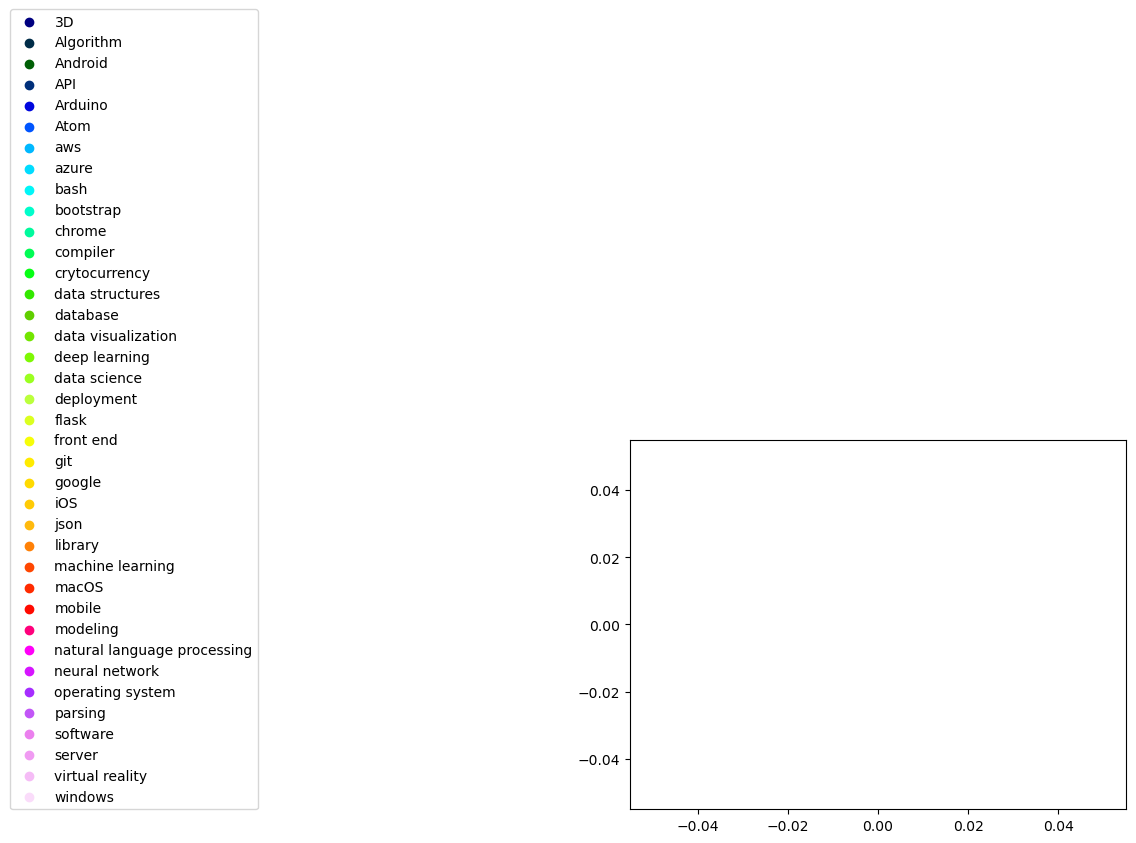

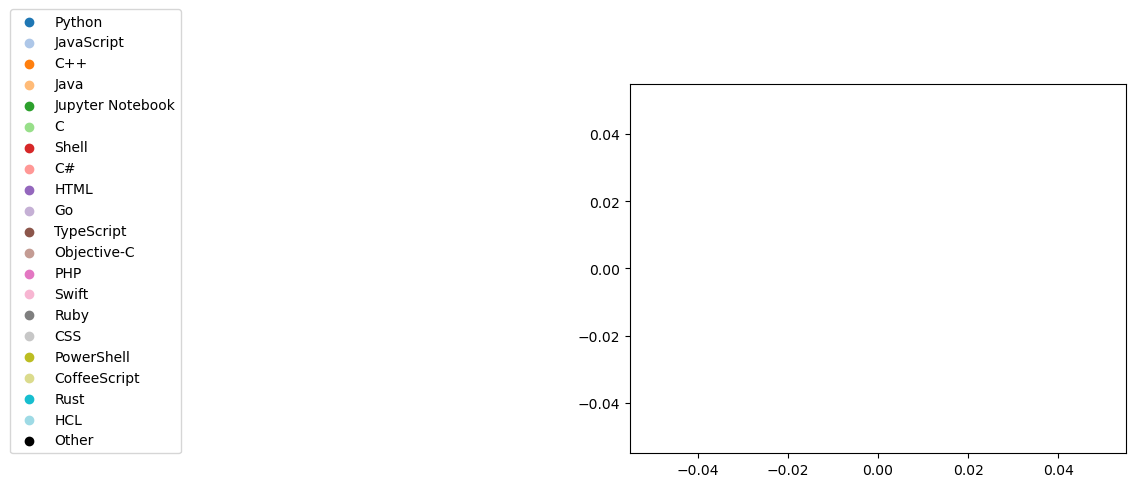

In [414]:
sn.get_coloring_legend()

#### For topic-repo and topic-contributor networks make multiple networks changing around threshold and k

In [366]:
sn = social_network()

In [368]:
for t in [10,50,100,200,400]:
    sn.make_network('topic-contributor', threshold=t, top_n=500)
    sn.visualize_network('topic-contributor', html = f'../networks/tc_network_threshold={t}.html')

In [369]:
for k in [0,1,2,4,8]:
    sn.make_network('topic-contributor', threshold=200, top_n=500)
    sn.visualize_network('topic-contributor', html = f'../networks/tc_network_k={k}.html', k=k)

In [374]:
for t in [5,10,30,20,50]:
    sn.make_network('topic-repo', threshold=t, top_n=500)
    sn.visualize_network('topic-repo', html = f'../networks/tr_network_threshold={t}.html')

In [378]:
for k in [0,1,2,4]:
    sn.make_network('topic-repo', threshold=20, top_n=500)
    sn.visualize_network('topic-repo', html = f'../networks/tr_network_k={k}.html', k=k)

In [462]:
for n in [5,10]:
    sn.visualize_network('repo-contributor', html = f'../networks/rc_network_n={n}_l.html', n=n)

In [463]:
for k in [2,5,10,20]:
    sn.visualize_network('repo-contributor', html = f'../networks/rc_network_k={k}_l.html', k=k)